In [1]:
import sys
sys.path.append("../") 

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import LISA as l

import Wavelet as wv
import Glitch as gl
import Glitch_MCMC as glmc
import MCMC_tools as mct


# constants
mHz = 1.0e-3
Hour = 3600.

In [60]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt

# set up the LISA orbit
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

print("Nyquist Freq........ {} mHz".format(orb.f_ny*1000.))

# set up parameters of wavelet
A    = 2.0e-20
f0   = 3.0*mHz
tau  = 10.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.


Q = 2*np.pi*f0*tau
print("tau................. {} s".format(tau))
print("Q................... {} s".format(Q))
print("dt.................. {} s".format(orb.dt))

# create wave object
wave = wv.Wavelet(A, f0, tau, t0, phi0, orb)
wave.calc_Psi()
wave.make_padded_Psi(t) # drop in the wavelet time series into the data stream

# create glitch
glitch = gl.Glitch(wave, 0, orb) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch.calc_TDI()
glitch.calc_snr()

# Adjust the SNR to desired target
glitch.adjust_snr(20)

glitch.calc_Fish()

Nyquist Freq........ 33.333333333333336 mHz
tau................. 37800.0 s
Q................... 712.5132138341651 s
dt.................. 15.0 s


In [3]:
Sn = l.get_Sn(f0)
SNRsq = np.sqrt(np.pi/2)*glitch.Wavelet.A**2*tau/(Sn)
print(SNRsq)
print(glitch.SNR**2)
A_lo = np.sqrt( np.sqrt(2/np.pi)*Sn/tau)
print(np.log(A_lo))

144.77494374905913
400.0
-51.69308871432235


In [4]:
e_vals, e_vecs = mct.get_Fihser_Eignen_BS(glitch.Fisher)
print (e_vals)

[7.08432229e-05 2.66202622e+02 7.69337067e+04 5.64083342e+06
 5.77343551e+11]


In [5]:
sample = glmc.Fisher_rvs(e_vals, e_vecs, glitch.params)

In [6]:
F_prop = glmc.Proposal(1, glmc.Fisher_rvs, glmc.Fisher_logpdf)
gl_prior = glmc.Prior(glmc.glitch_prior_logpdf)

In [7]:
print(F_prop.rvs(e_vals, e_vecs, glitch.params))
print(F_prop.logpdf())

[-49.2054985   10.0003812    0.81269841   0.0625       1.
   0.        ]
1.0


In [8]:
gl_prior.logpdf(glitch.params)

-1.8378770664093453

In [9]:
modelX = glmc.Model(glitch, orb, gl_prior, F_prop)
modelX.loglkl = modelX.log_lkl(glitch.TDI)

In [10]:
glitch.calc_Fish()
print(glitch.Fisher)

[[ 4.00000001e+02  9.55719661e-01 -5.81296504e-04  3.19999985e+03
  -9.85644068e-09]
 [ 9.55719661e-01  5.64083341e+06  1.31269450e-01 -7.64544900e+00
  -3.35566637e-06]
 [-5.81296504e-04  1.31269450e-01  5.77343551e+11  5.11192230e-04
  -1.51966243e+07]
 [ 3.19999985e+03 -7.64544900e+00  5.11192230e-04  7.67999094e+04
  -1.83572638e-07]
 [-9.85644068e-09 -3.35566637e-06 -1.51966243e+07 -1.83572638e-07
   4.00000018e+02]]


In [11]:
paramsY = F_prop.rvs(e_vals, e_vecs, glitch.params)

A = np.exp(paramsY[wv.IDX_lnA])
f0 = paramsY[wv.IDX_f0]*mHz
t0 = paramsY[wv.IDX_t0]*Week
tau = paramsY[wv.IDX_tau]*Week
phi0 = paramsY[wv.IDX_phi0]

waveY = wv.Wavelet(A, f0, tau, t0, phi0, orb)
waveY.calc_Psi()
waveY.make_padded_Psi(t)


glitchY = gl.Glitch(waveY, 0, orb) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitchY.calc_TDI()
glitchY.calc_snr()

modelY = glmc.Model(glitchY, orb, gl_prior, F_prop)
modelY.loglkl = modelY.log_lkl(glitch.TDI)

In [12]:
modelX.log_lkl(glitch.TDI)

200.00000000031838

In [13]:
import TDI as td
np.sum(td.get_TDI_overlap(glitch.TDI, glitch.TDI, glitch.TDI.f_min, glitch.TDI.f_max))

400.0000000003184

In [14]:
glitch.SNR

20.0

In [15]:
link = glmc.Link(modelX, modelY, 1)

In [16]:
link.decide(glitch.TDI, 1.0)

1

In [66]:
comp_switch = 0
PT = 0
flag = glmc.Flag(comp_switch, PT)

###### TESTING OTHER COMPONENT SHIT ######
A    = 2.0e-20
f0   = 3.0*mHz
tau  = 10.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.
wave = wv.Wavelet(A, f0, tau, t0, phi0, orb)
wave.calc_Psi()
wave.make_padded_Psi(t) 
glitch_init = gl.Glitch(wave, 8, orb) 
glitch_init.calc_TDI()
glitch_init.calc_snr()
glitch_init.adjust_snr(20)
glitch_init.calc_Fish()
modelX = glmc.Model(glitch_init, orb, gl_prior, F_prop)
modelX.loglkl = modelX.log_lkl(glitch.TDI)
print(modelX.loglkl)

158.6390386748922


In [67]:
lkl, chain, props, max_model = glmc.glitch_MCMC(glitch.TDI, orb, modelX, 1, 1000, flag)
FF = (max_model.loglkl + 0.5*max_model.Glitch.SNR**2)/max_model.Glitch.SNR/modelX.Glitch.SNR
print("FF......... {}".format(FF))

acceptance rate......... [77.3]%
swap acceptance rate.... []%
max logL................ 161.68682327897298
FF......... 0.8991626067800538


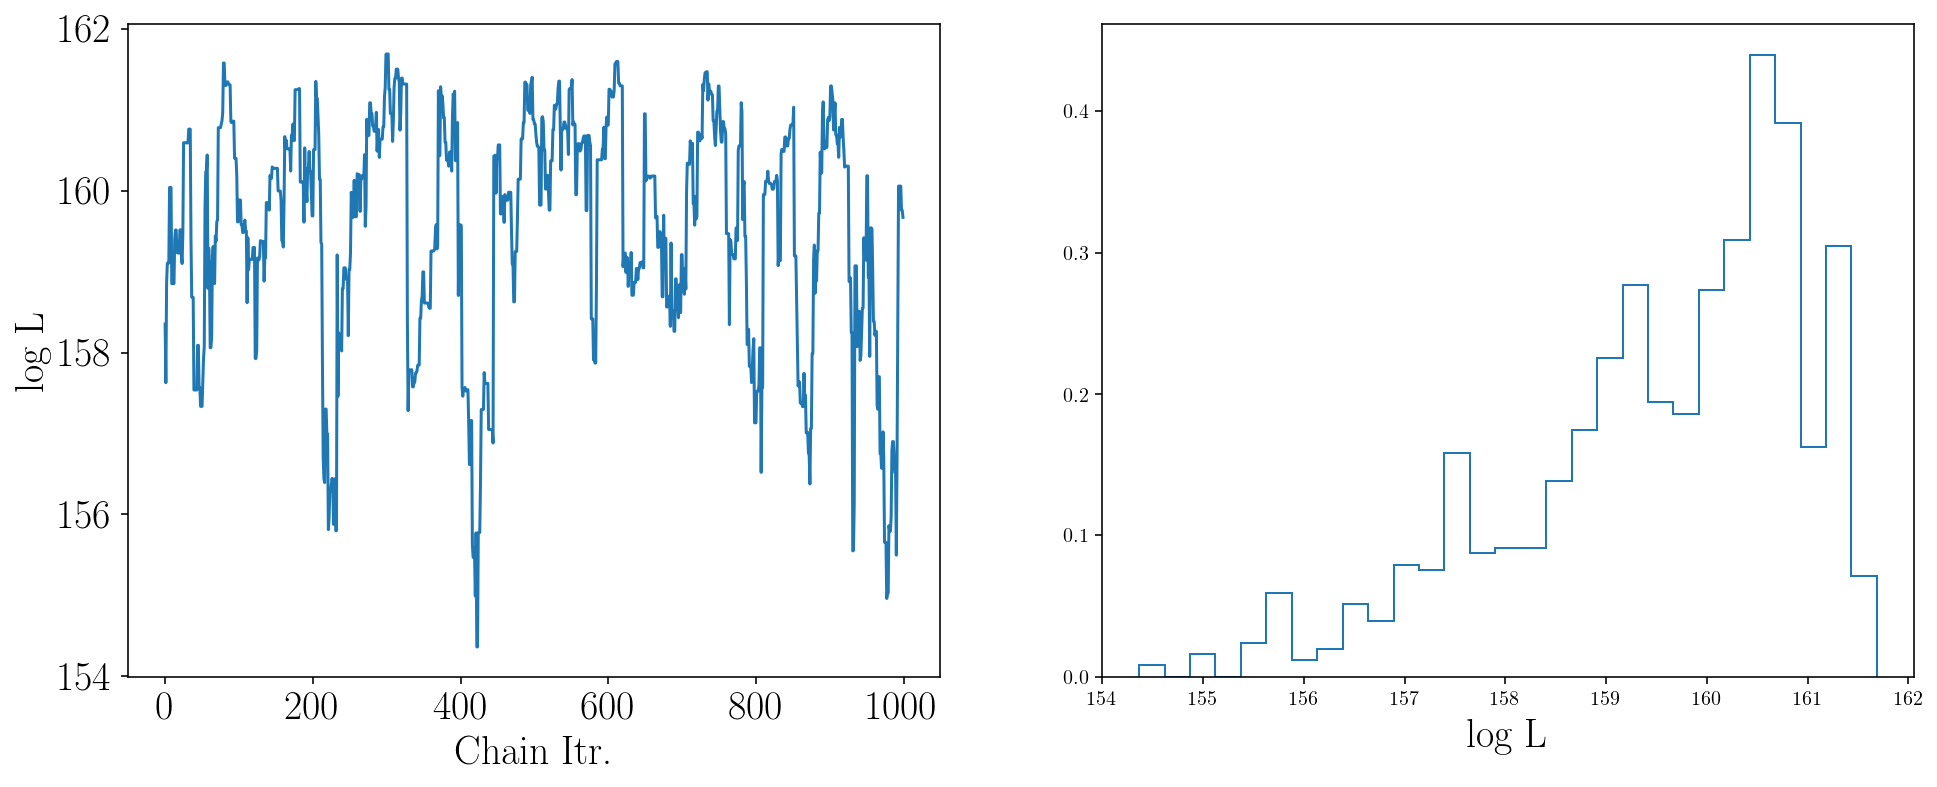

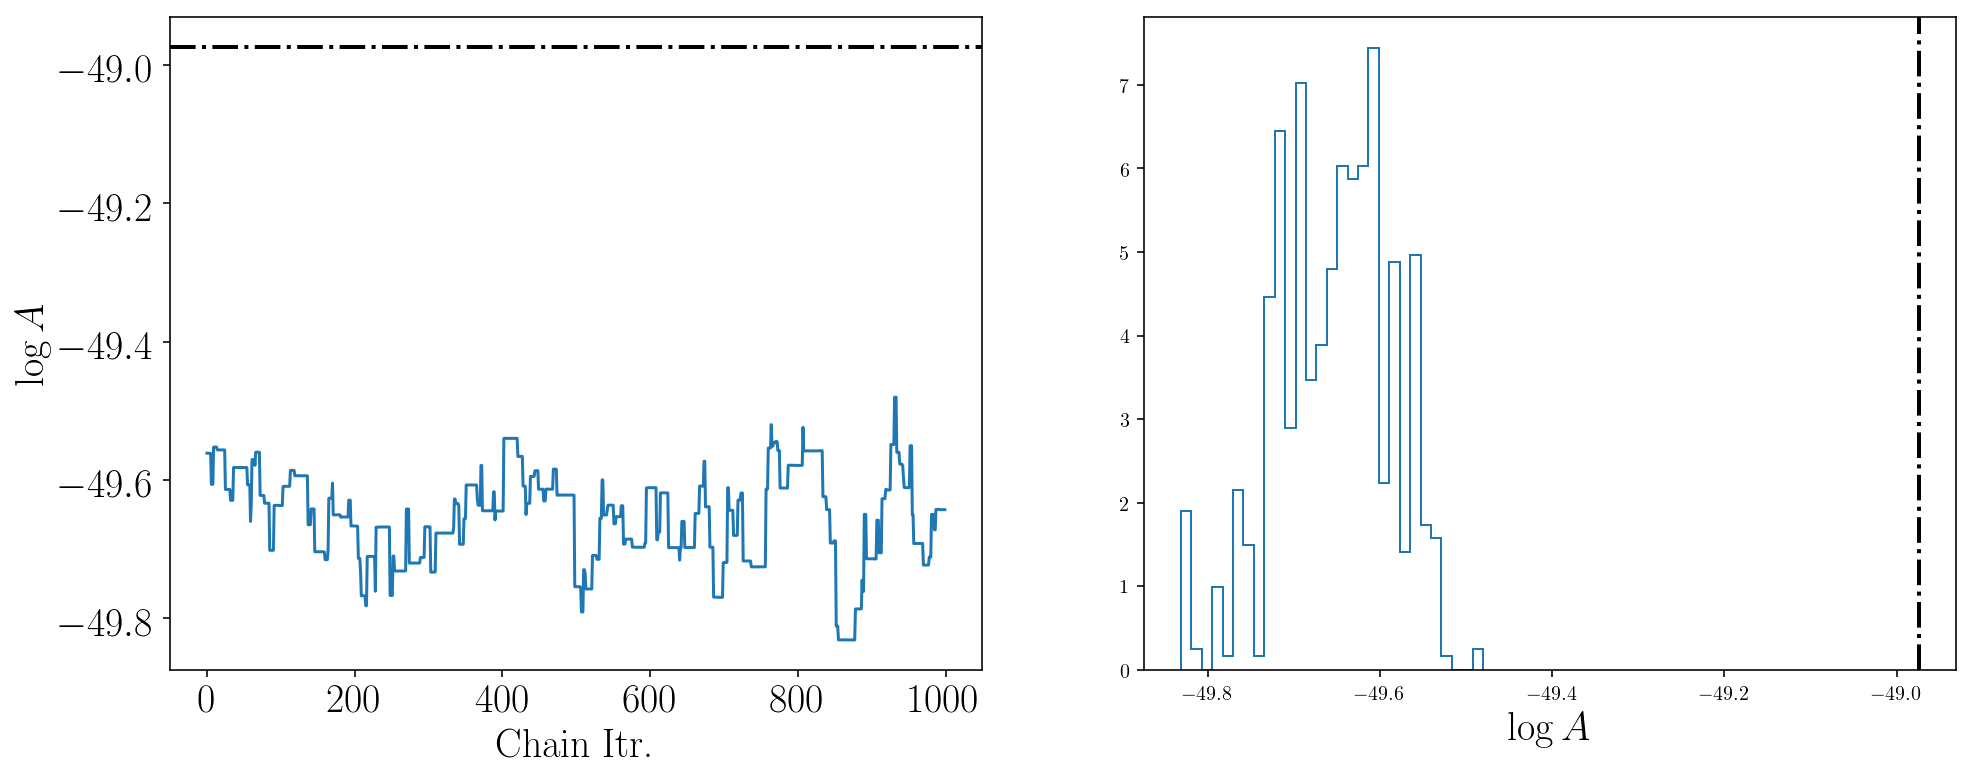

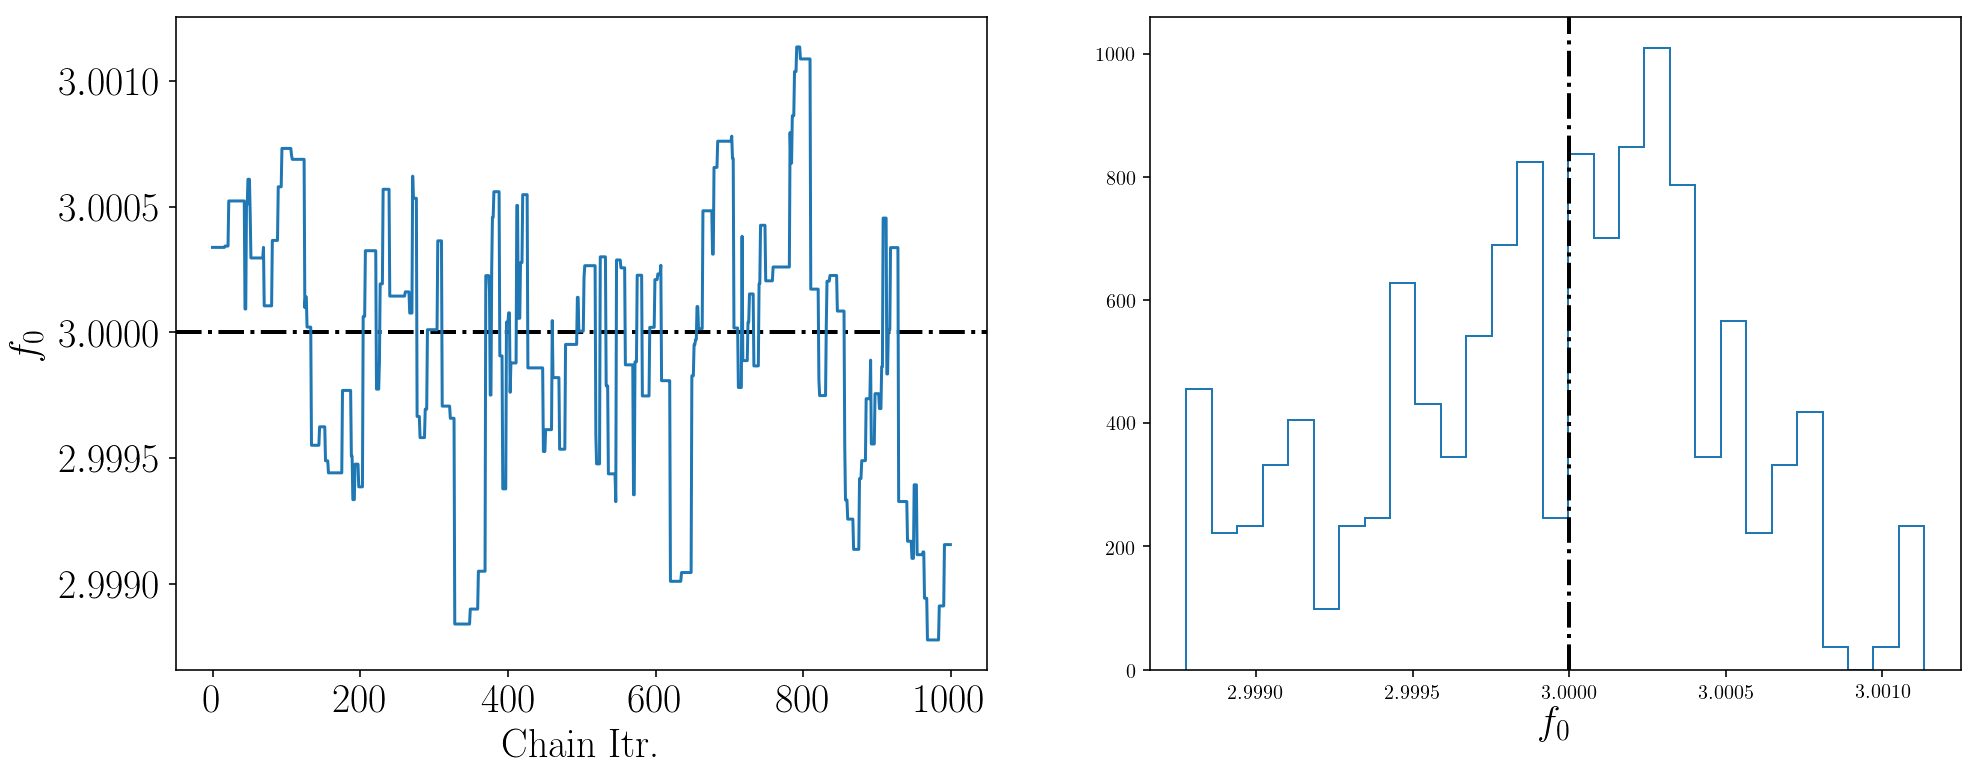

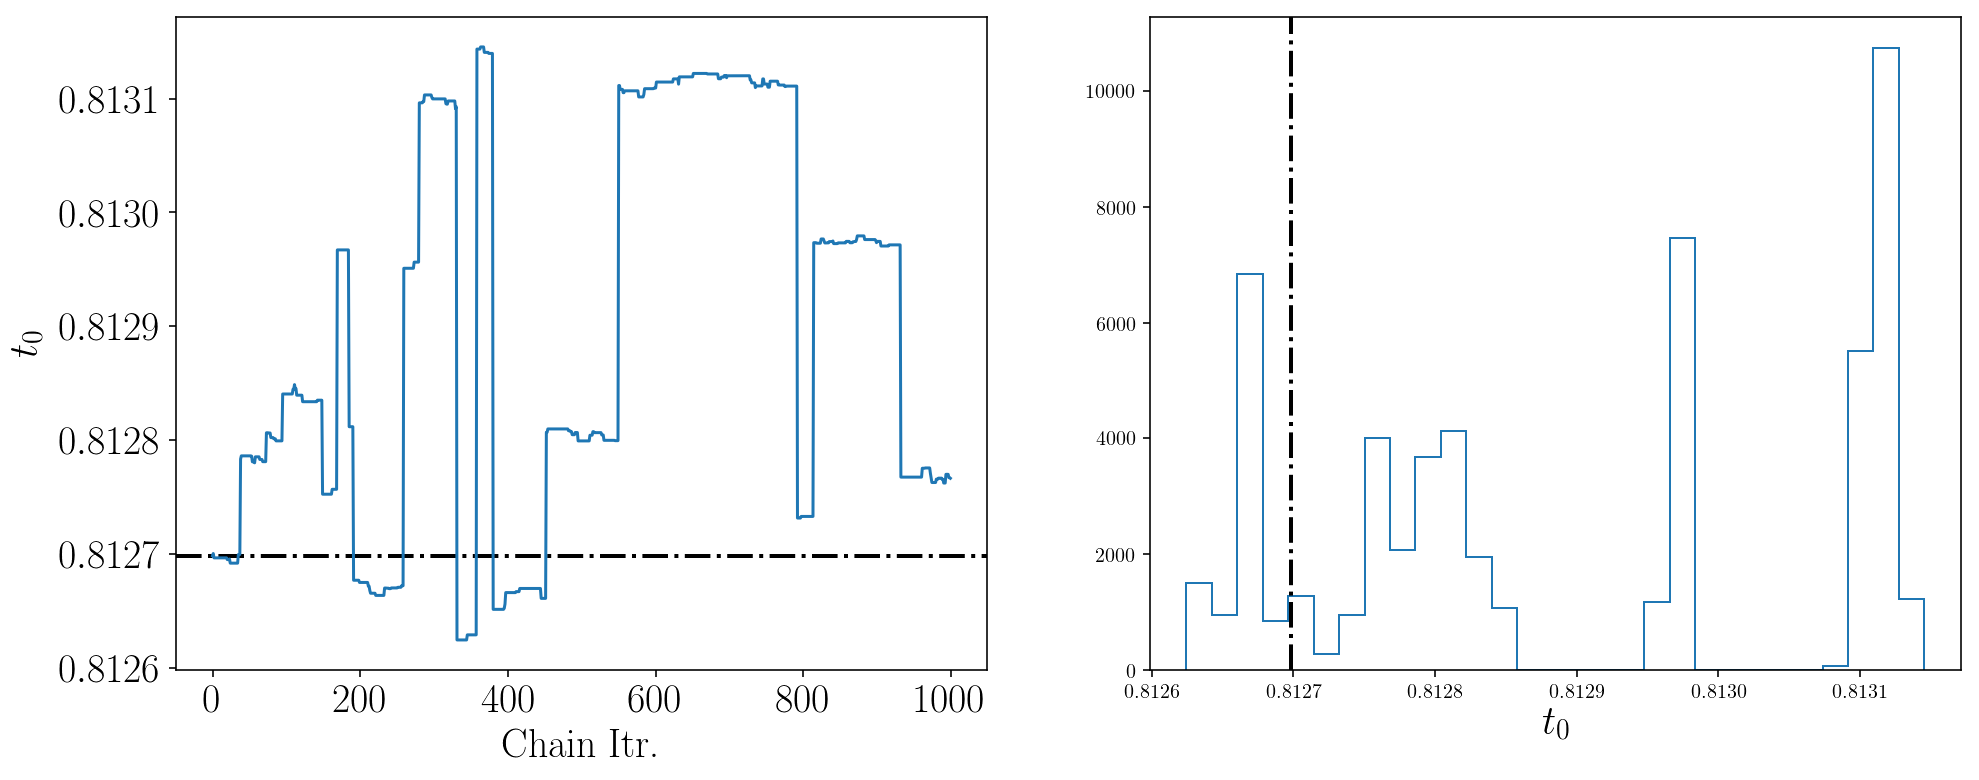

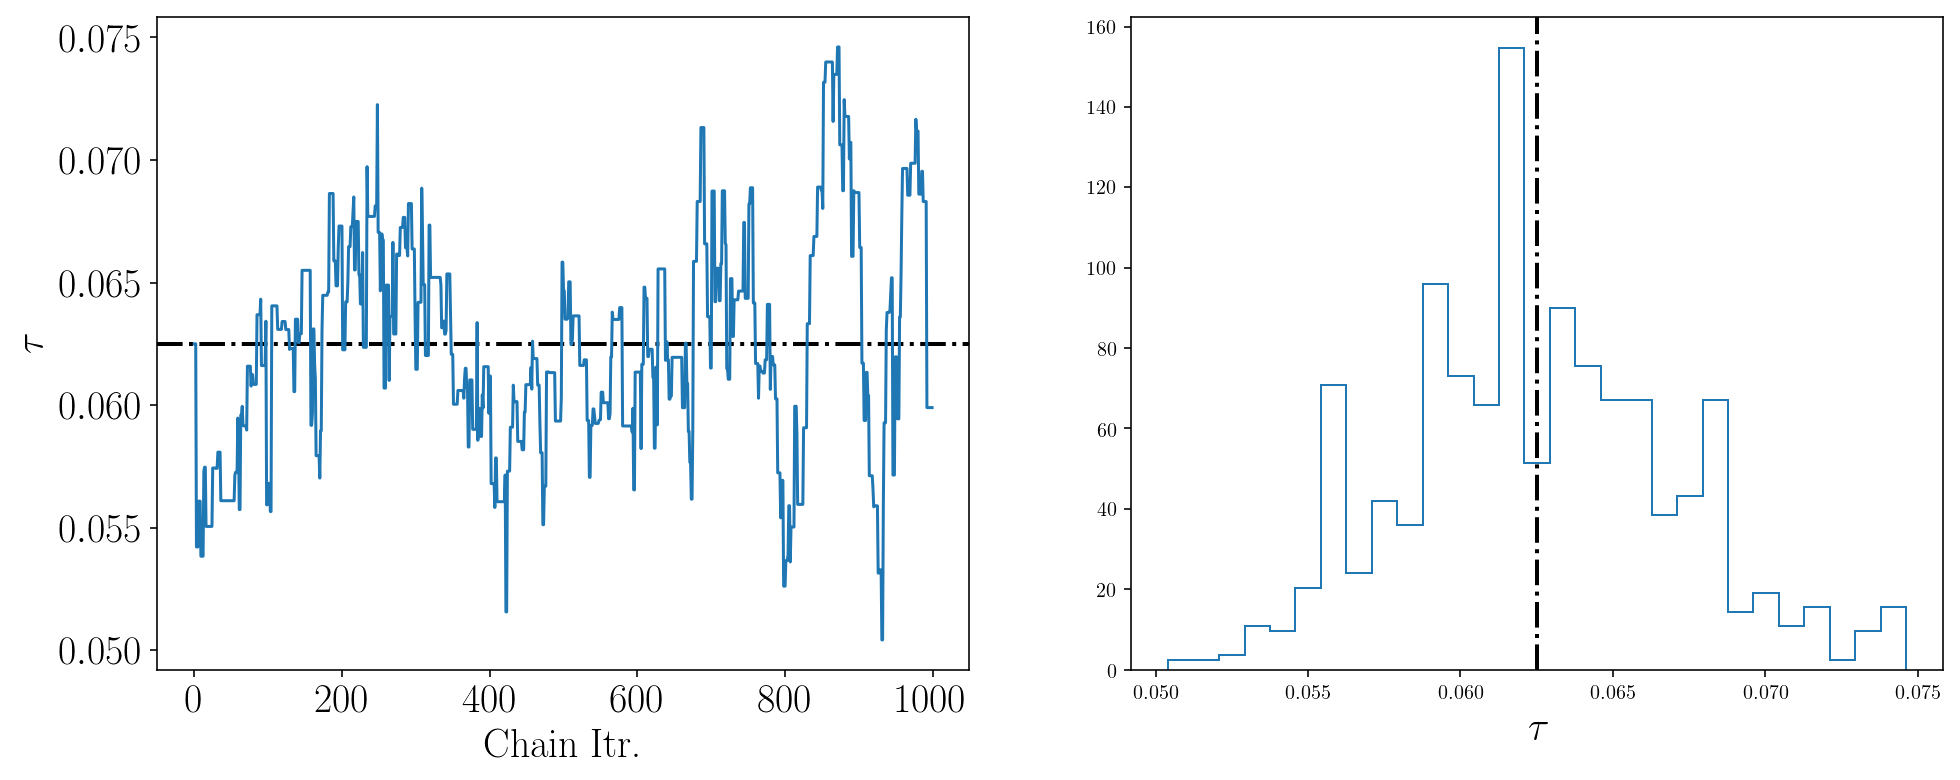

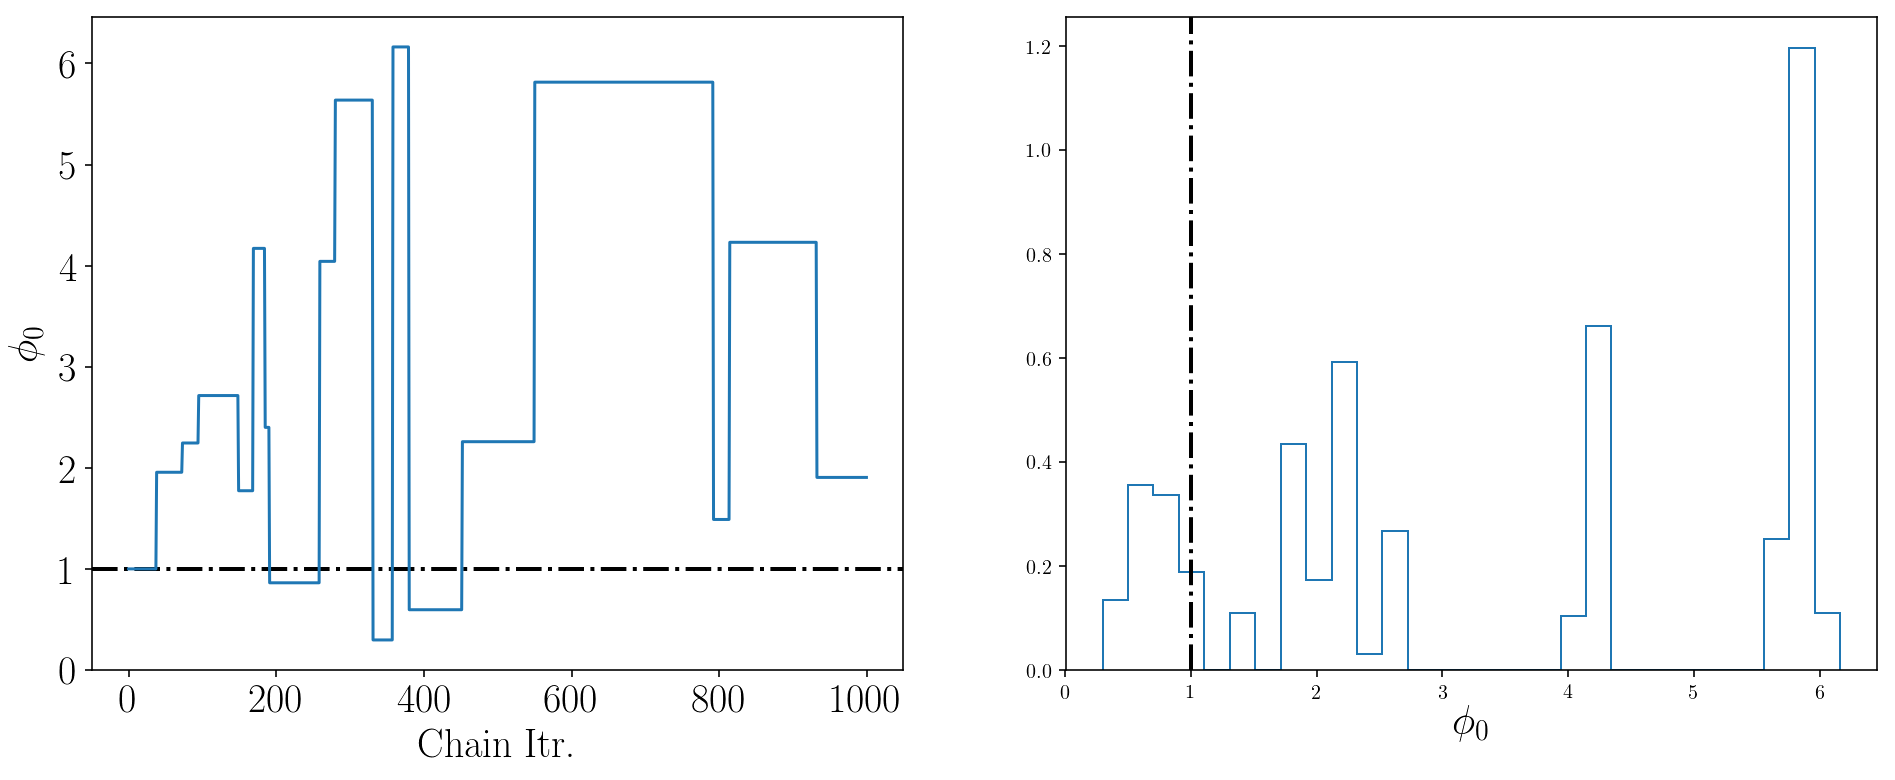

In [68]:
n_bins = 30
mct.plot_chain(lkl[:,0], r'log L', n_bins)
mct.plot_chain(chain[0,:,0], r'$\log A$',   n_bins, np.log(glitch.Wavelet.A))
mct.plot_chain(chain[1,:,0], r'$f_{0}$',    n_bins, glitch.Wavelet.f0/mHz)
mct.plot_chain(chain[2,:,0], r'$t_{0}$',    n_bins, glitch.Wavelet.t0/Week)
mct.plot_chain(chain[3,:,0], r'$\tau$',     n_bins, glitch.Wavelet.tau/Week)
mct.plot_chain(chain[4,:,0], r'$\phi_{0}$', n_bins, glitch.Wavelet.phi0)


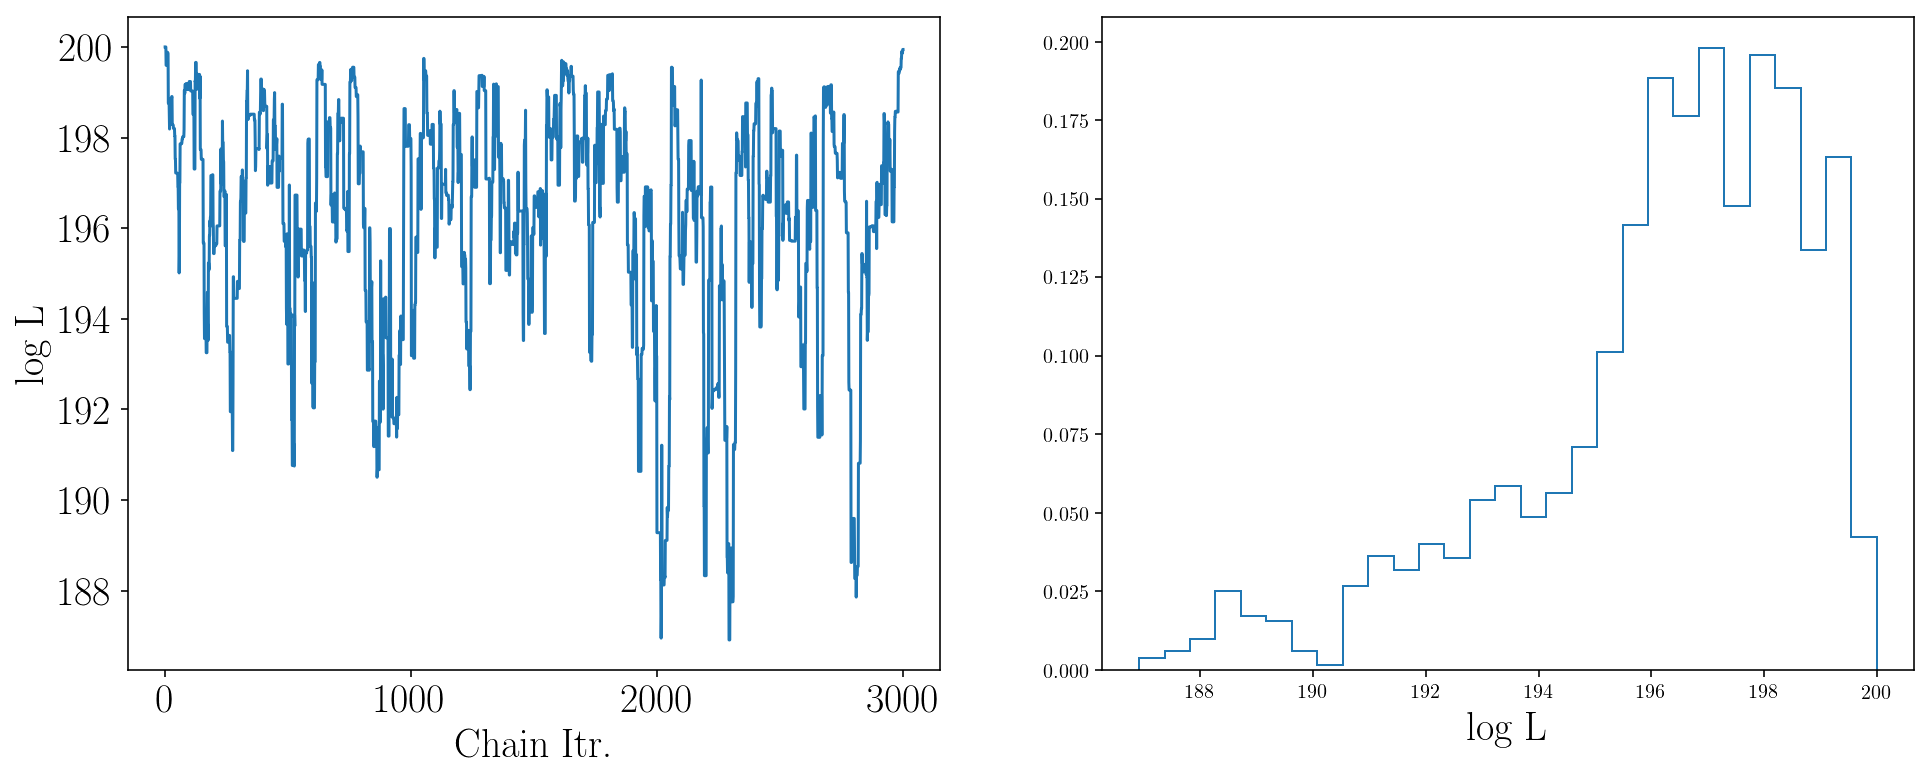

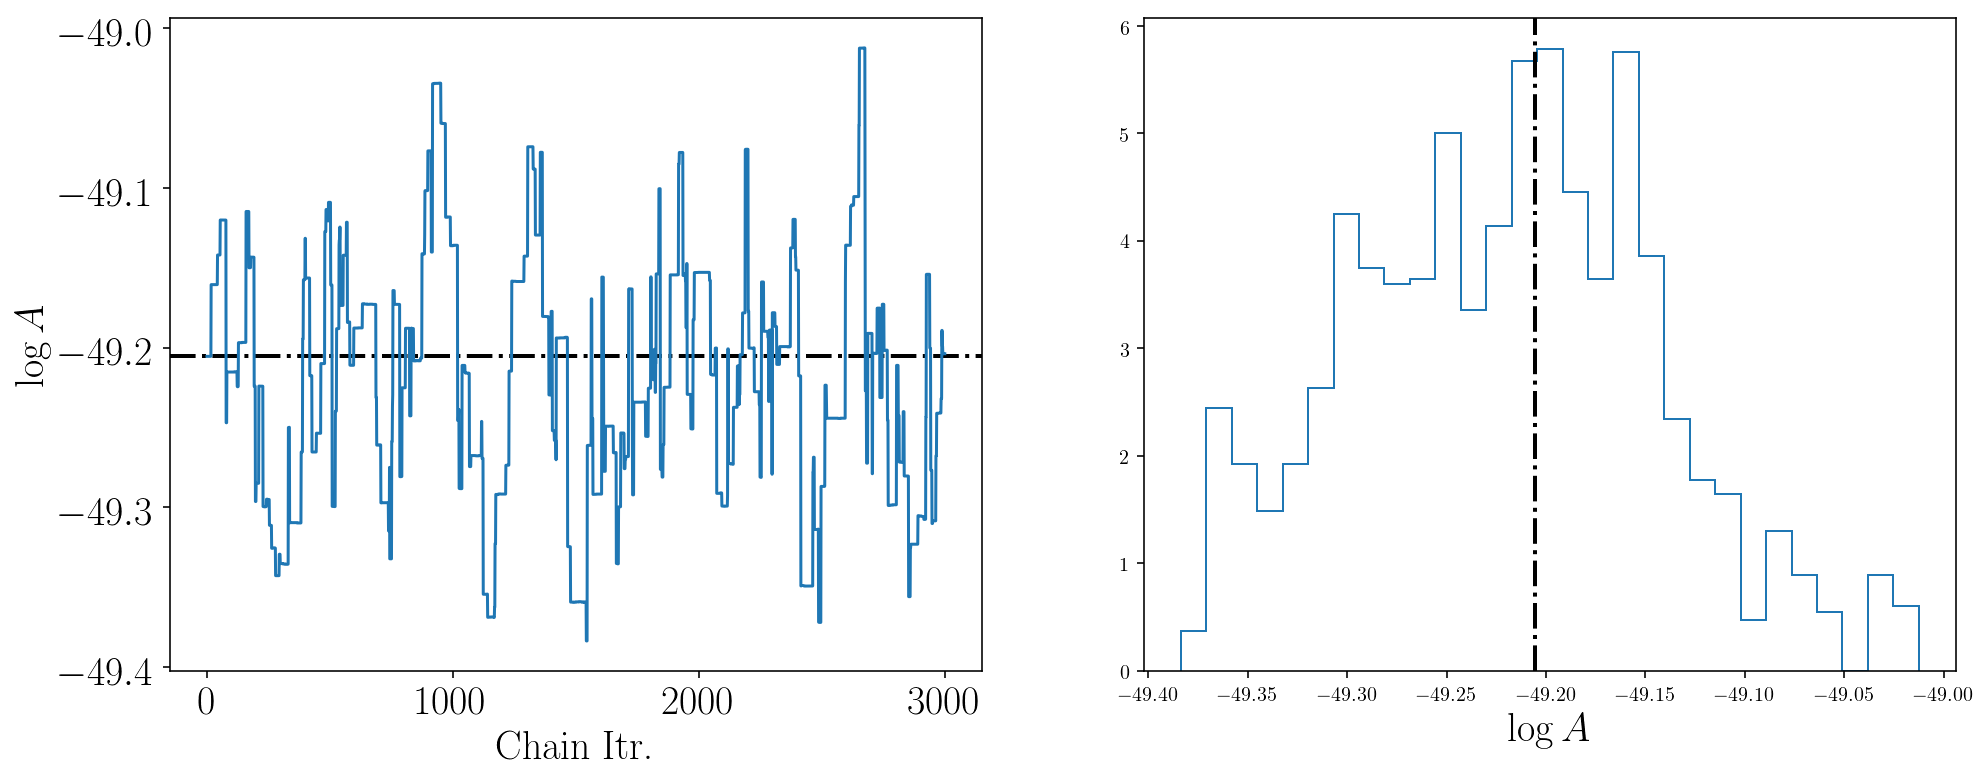

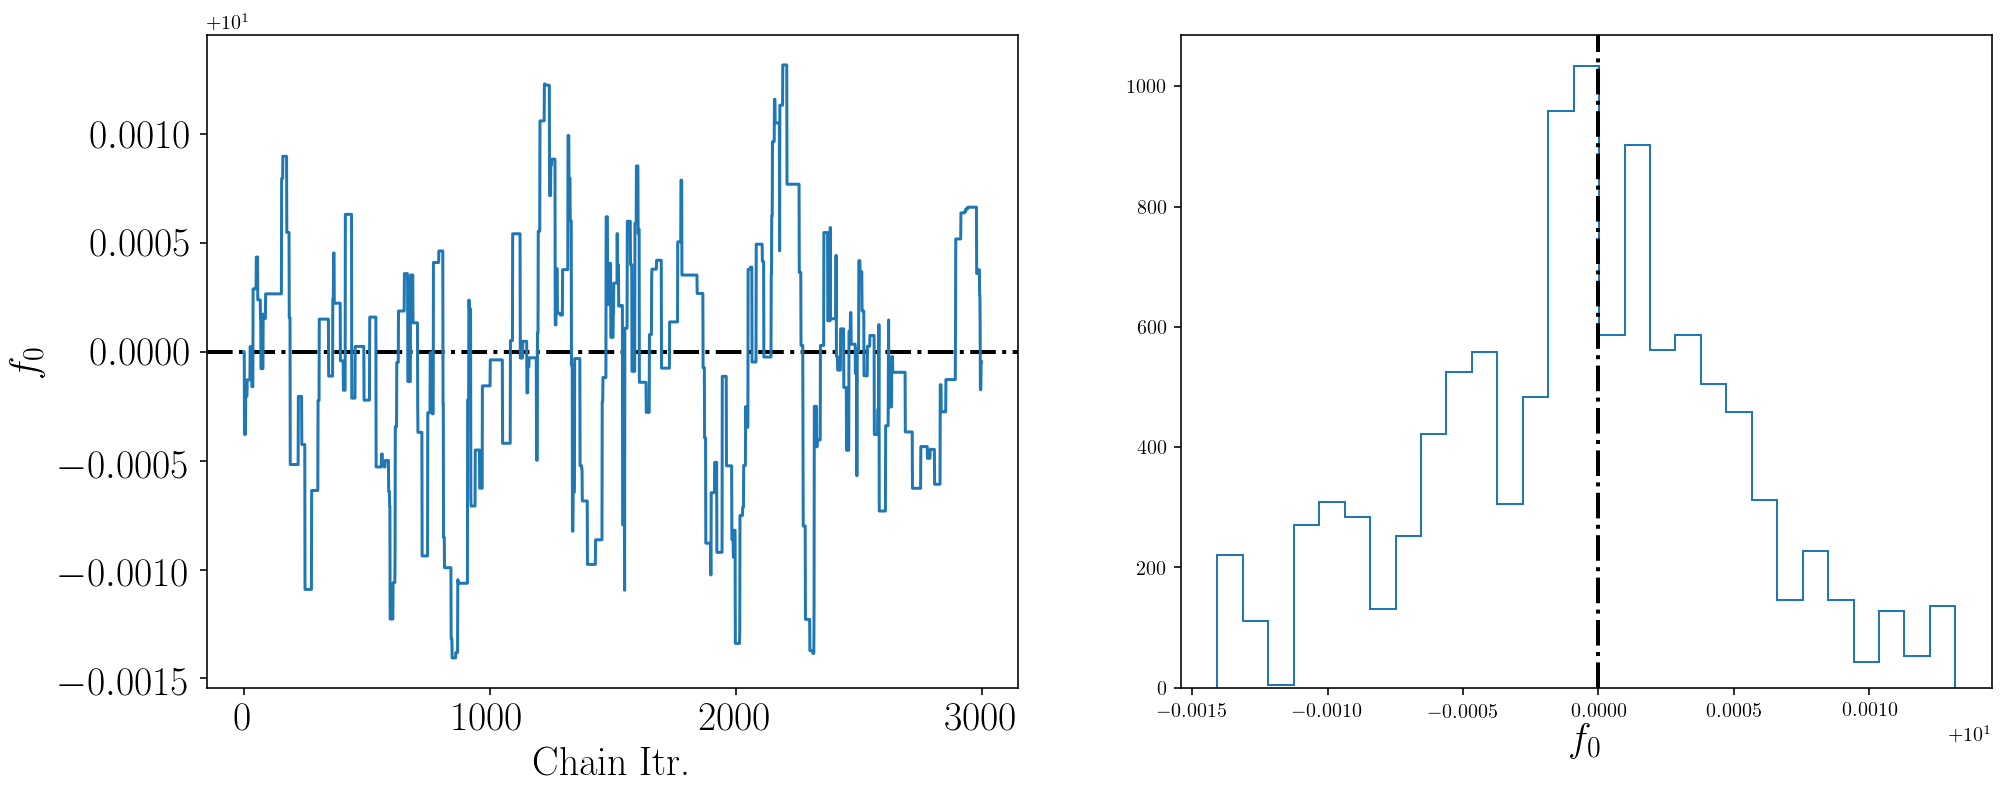

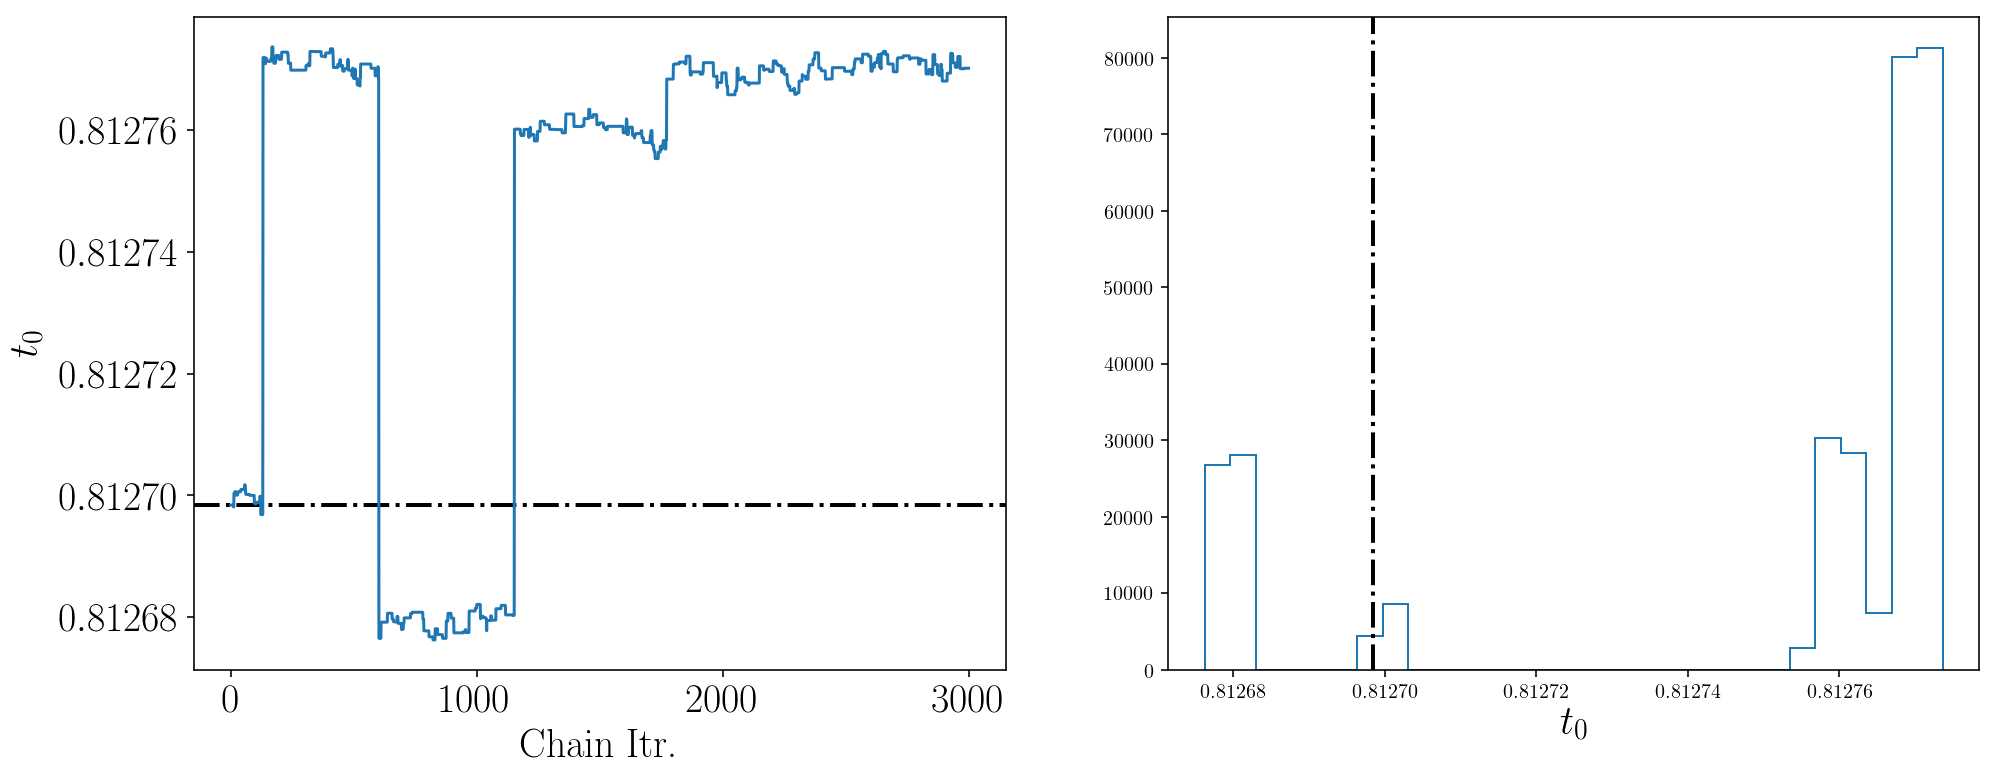

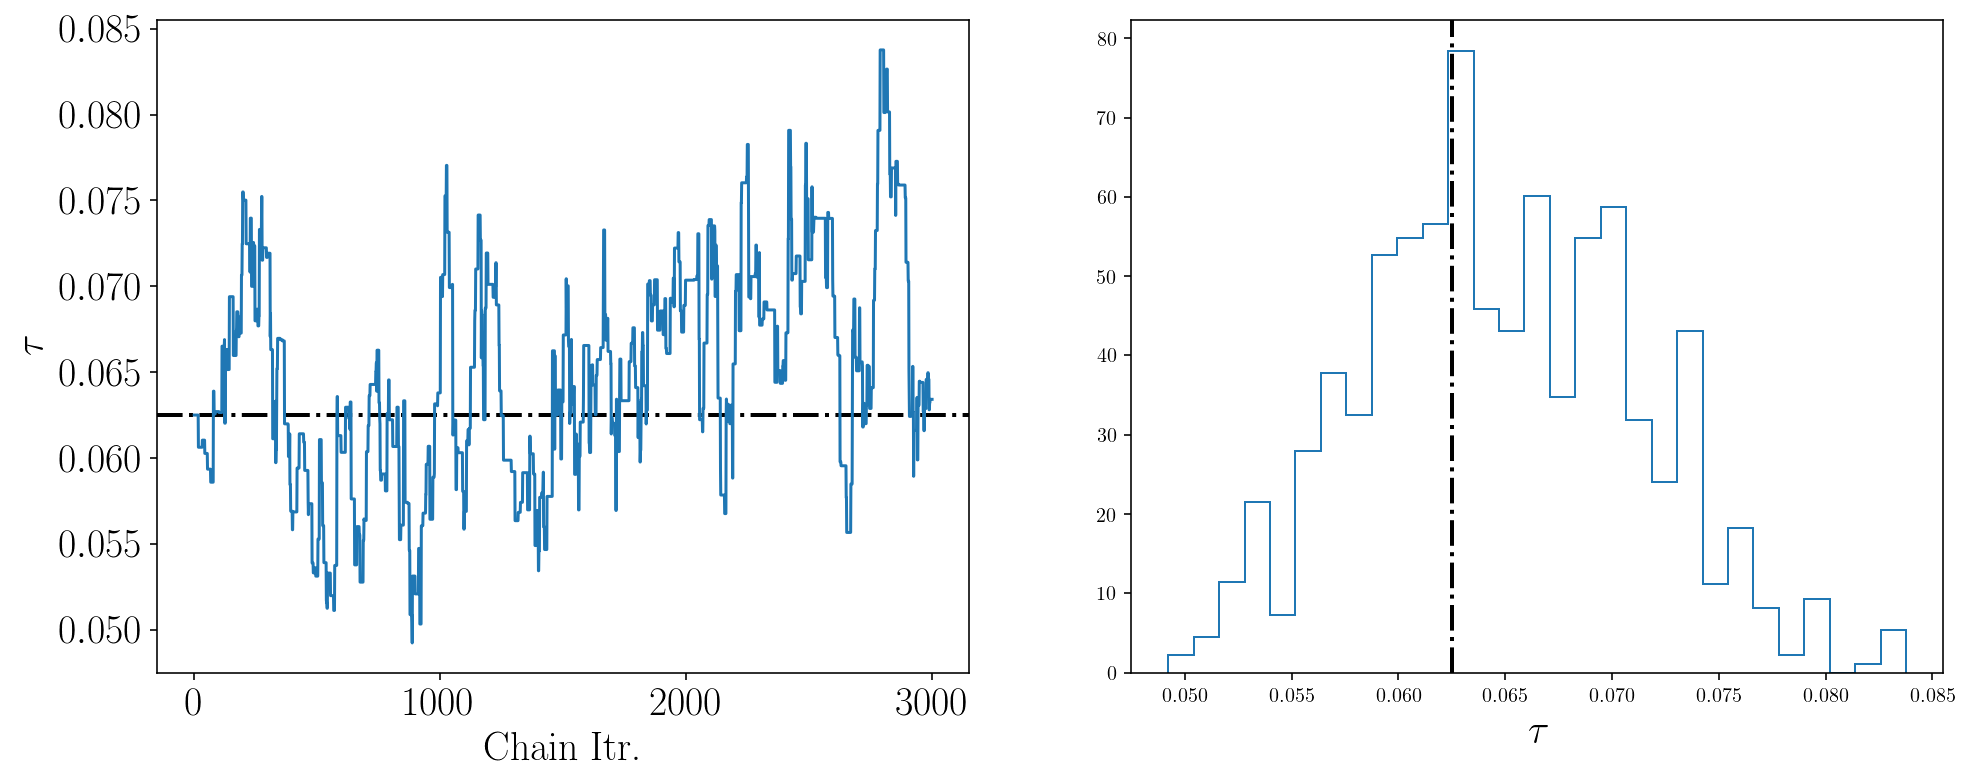

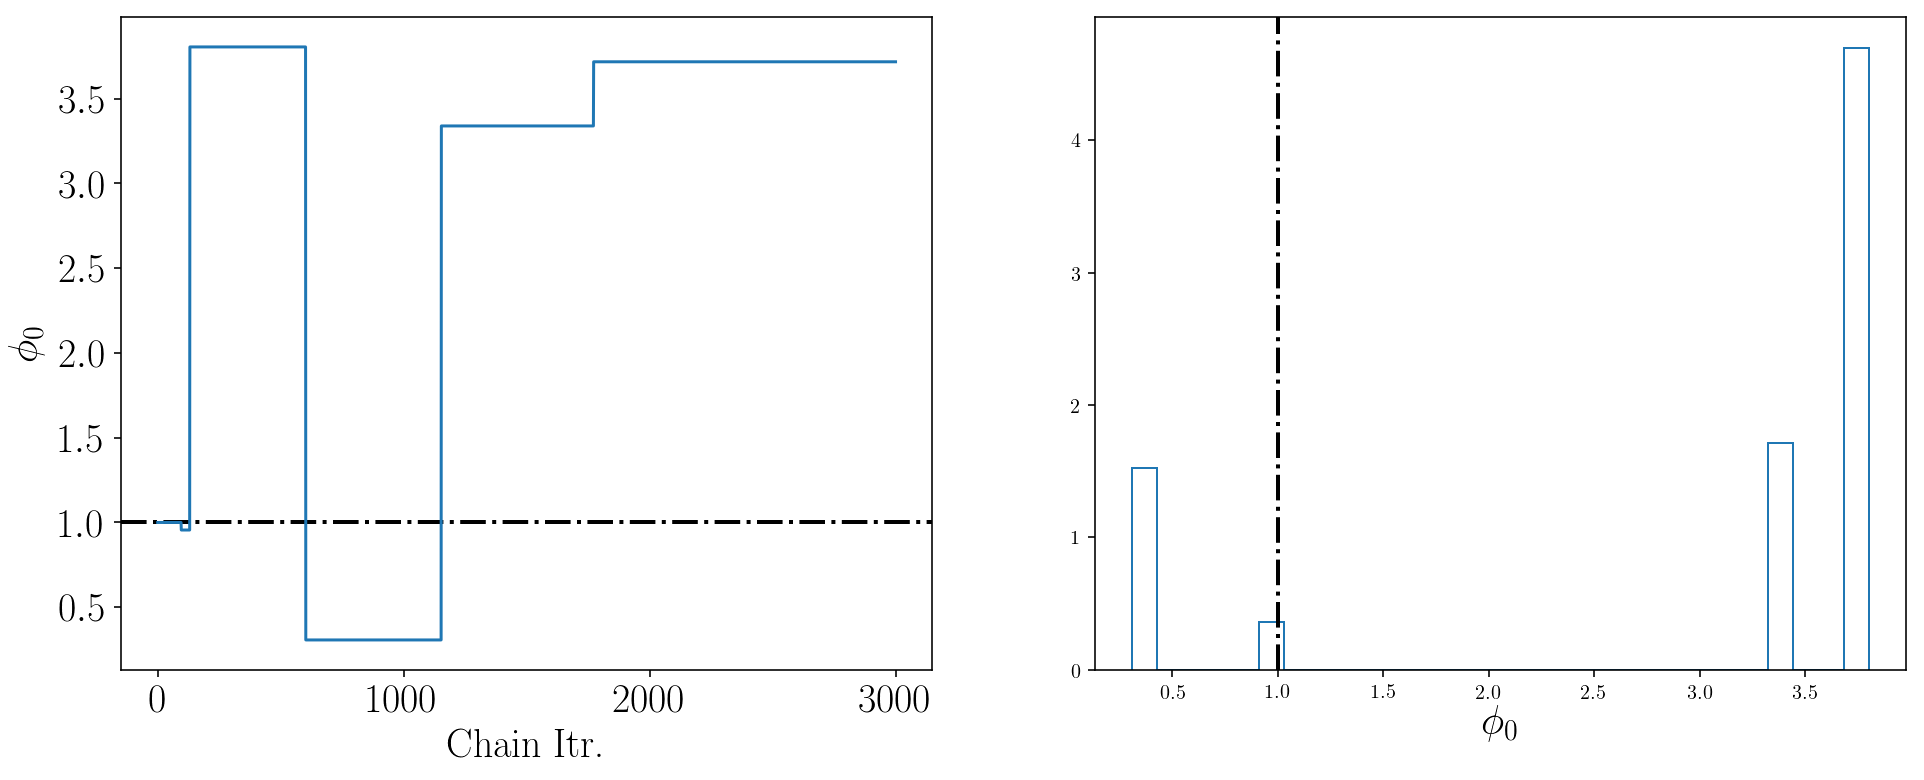

In [32]:
n_bins = 30
mct.plot_chain(lkl[:,1], r'log L', n_bins)
mct.plot_chain(chain[0,:,1], r'$\log A$',   n_bins, np.log(glitch.Wavelet.A))
mct.plot_chain(chain[1,:,1], r'$f_{0}$',    n_bins, glitch.Wavelet.f0/mHz)
mct.plot_chain(chain[2,:,1], r'$t_{0}$',    n_bins, glitch.Wavelet.t0/Week)
mct.plot_chain(chain[3,:,1], r'$\tau$',     n_bins, glitch.Wavelet.tau/Week)
mct.plot_chain(chain[4,:,1], r'$\phi_{0}$', n_bins, glitch.Wavelet.phi0)



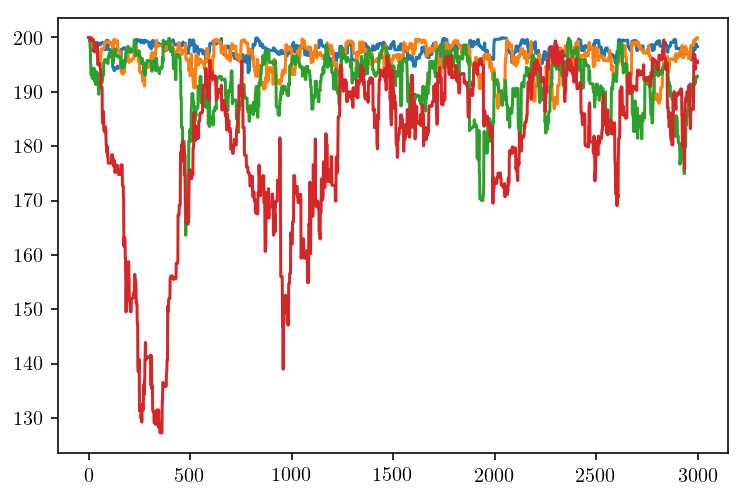

In [33]:
plt.plot(lkl[:,0])
plt.plot(lkl[:,1])
plt.plot(lkl[:,2])
plt.plot(lkl[:,3])
#plt.plot(lkl[:,4])
plt.show()


In [34]:
print(mct.get_autocorr_length(chain[0,:,0]))
print(mct.get_autocorr_length(chain[1,:,0]))
print(mct.get_autocorr_length(chain[2,:,0]))
print(mct.get_autocorr_length(chain[3,:,0]))
print(mct.get_autocorr_length(chain[4,:,0]))

206
153
868
354
866


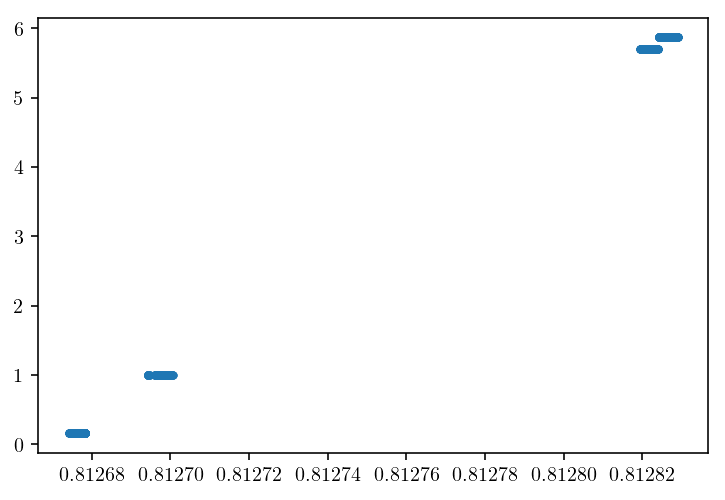

In [35]:
# there is of course a huge correlation between t0 and phi0
plt.plot(chain[2,:,0], chain[4,:,0], '.')
plt.show()

In [36]:
#%prun glmc.glitch_MCMC(glitch.TDI, orb, modelX, 1, 1000)

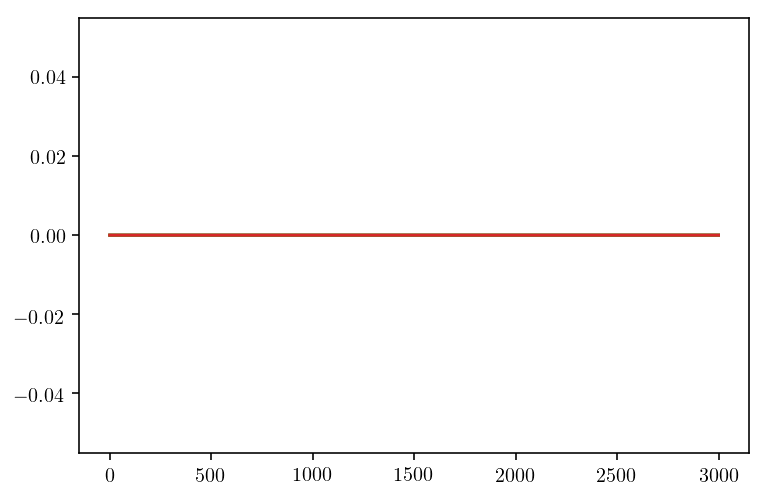

In [37]:
plt.plot(chain[5,:,0])
plt.plot(chain[5,:,1])
plt.plot(chain[5,:,2])
plt.plot(chain[5,:,3])
plt.show()

In [26]:
1/(2*np.pi*l.fstar)/Week

1.3788198379553242e-05